In [1]:
import os
import errno
import numpy as np 
import deepcell
from deepcell_toolbox.multiplex_utils import multiplex_preprocess

In [2]:
# create folder for this set of experiments
experiment_folder = "image_distortion"
MODEL_DIR = os.path.join("/data/analyses", experiment_folder)
NPZ_DIR = "/data/npz_data/20201018_freeze/"
LOG_DIR = '/data/logs'

In [3]:
from deepcell.model_zoo.panopticnet import PanopticNet

model = PanopticNet(
    backbone='resnet50',
    input_shape=(256,256, 2),
    norm_method=None,
    num_semantic_heads=2,
    num_semantic_classes=[1, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True,
    use_imagenet=False)

W1202 20:29:35.990097 140476373436224 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
from deepcell_toolbox.deep_watershed import deep_watershed_mibi
import scipy.ndimage as nd
metrics = {}
for model_split in ['1', '2', '3']:
    print('analyzing split {}'.format(model_split))
    weights = '/data/analyses/size_benchmarking/20201018_multiplex_seed_{}__subset_2665.h5'.format(model_split)
    model.load_weights(weights)
    
    test_dict = np.load(NPZ_DIR + "20201018_multiplex_seed_{}_test_256x256.npz".format(model_split))
    X_test, y_test = test_dict['X'], test_dict['y']
    tissue_list, platform_list = test_dict['tissue_list'], test_dict['platform_list']        
    current_dict = {}
    print("smooth for loop")
    for smooth_factor in np.arange(0, 5.5, 0.5):
        print('smooth factor {}'.format(smooth_factor))
        X_test_smooth = np.zeros_like(X_test)
        for img in range(X_test.shape[0]):
            for channel in [0, 1]:
                X_test_smooth[img, :, :, channel] = nd.gaussian_filter(X_test[img, :, :, channel].astype('float32'), 
                                                                       smooth_factor)    

        X_test_processed = multiplex_preprocess(X_test_smooth)

        print("creating predictions")
        inner_distance, pixelwise = model.predict(X_test_processed)

        print('postprocessing')
        labeled_images = deep_watershed_mibi({'inner-distance': inner_distance[:, :, :, :],
                                         'pixelwise-interior': pixelwise[:, :, :, 1:2]}, 
                                         maxima_threshold=0.1, maxima_model_smooth=0,
                                        interior_threshold=0.25, interior_model_smooth=2,
                                        radius=3,
                                        small_objects_threshold=10,
                                         fill_holes_threshold=10)
        print("calculating accuracy")
        db = DatasetBenchmarker(y_true=y_test, 
                           y_pred=labeled_images,
                           tissue_list=tissue_list,
                           platform_list=platform_list,
                           model_name='default_model')
        tissue_stats, platform_stats = db.benchmark()
        current_dict[str(smooth_factor)] = tissue_stats
    metrics[model_split] = current_dict
np.savez_compressed(os.path.join(MODEL_DIR, 'blurring_metrics_triplicate.npz'), **metrics)

analyzing split 1
smooth for loop
smooth factor 0.0
creating predictions
postprocessing
calculating accuracy

____________Object-based statistics____________

Number of true cells:		 139873
Number of predicted cells:	 137206

Correct detections:  114717	Recall: 82.0151%
Incorrect detections: 22489	Precision: 83.6093%

Gained detections: 13575	Perc Error: 39.6362%
Missed detections: 14856	Perc Error: 43.3764%
Merges: 3068		Perc Error: 8.9579%
Splits: 2015		Perc Error: 5.8834%
Catastrophes: 735		Perc Error: 2.146%

Gained detections from splits: 2167
Missed detections from merges: 3424
True detections involved in catastrophes: 925
Predicted detections involved in catastrophes: 864 

Average Pixel IOU (Jaccard Index): 0.8668 

uid is breast
uid is gi
uid is immune
uid is lung
uid is pancreas
uid is skin
uid is codex
uid is cycif
uid is imc
uid is mibi
uid is mxif
uid is vectra
uid is all
smooth factor 0.5
creating predictions
postprocessing
calculating accuracy


In [15]:
metrics['3']['1.0']['all']['f1']

0.802484169508037

In [16]:
np.savez_compressed(os.path.join(MODEL_DIR, 'blurring_metrics_triplicate.npz'), **metrics)

In [ ]:
from deepcell_toolbox.deep_watershed import deep_watershed_mibi
from deepcell_toolbox.utils import resize
metrics = {}
for model_split in ['1', '2', '3']:
    print('analyzing split {}'.format(model_split))
    weights = '/data/analyses/size_benchmarking/20201018_multiplex_seed_{}__subset_2665.h5'.format(model_split)
    model.load_weights(weights)
    
    test_dict = np.load(NPZ_DIR + "20201018_multiplex_seed_{}_test_256x256.npz".format(model_split))
    X_test, y_test = test_dict['X'], test_dict['y']
    tissue_list, platform_list = test_dict['tissue_list'], test_dict['platform_list']        
    current_dict = {}
    print("downsample for loop")
    for downsample in np.arange(0.1, 1.1, .1):
        pixel_size = int(256 * downsample)
        print('downsample size {}'.format(pixel_size))
        X_test_downsized = resize(X_test.astype('float32'), (pixel_size, pixel_size))
        X_test_resized = resize(X_test_downsized, (256, 256))

        X_test_processed = multiplex_preprocess(X_test_resized)

        print("creating predictions")
        inner_distance, pixelwise = model.predict(X_test_processed)

        print('postprocessing')
        labeled_images = deep_watershed_mibi({'inner-distance': inner_distance[:, :, :, :],
                                         'pixelwise-interior': pixelwise[:, :, :, 1:2]}, 
                                         maxima_threshold=0.1, maxima_model_smooth=0,
                                        interior_threshold=0.25, interior_model_smooth=2,
                                        radius=3,
                                        small_objects_threshold=10,
                                         fill_holes_threshold=10)
        print("calculating accuracy")
        db = DatasetBenchmarker(y_true=y_test, 
                           y_pred=labeled_images,
                           tissue_list=tissue_list,
                           platform_list=platform_list,
                           model_name='default_model')
        tissue_stats, platform_stats = db.benchmark()
        current_dict[str(downsample)] = tissue_stats
    metrics[model_split] = current_dict
np.savez_compressed(os.path.join(MODEL_DIR, 'resize_metrics_triplicate.npz'), **metrics)

analyzing split 1
downsample for loop
downsample size 25
creating predictions
postprocessing
calculating accuracy

____________Object-based statistics____________

Number of true cells:		 139873
Number of predicted cells:	 53449

Correct detections:  16205	Recall: 11.5855%
Incorrect detections: 37244	Precision: 30.3186%

Gained detections: 9581	Perc Error: 13.6515%
Missed detections: 34259	Perc Error: 48.8138%
Merges: 25124		Perc Error: 35.7978%
Splits: 27		Perc Error: 0.0385%
Catastrophes: 1192		Perc Error: 1.6984%

Gained detections from splits: 27
Missed detections from merges: 57607
True detections involved in catastrophes: 3507
Predicted detections involved in catastrophes: 1386 

Average Pixel IOU (Jaccard Index): 0.7036 

uid is breast
uid is gi
uid is immune
uid is lung
uid is pancreas
uid is skin
uid is codex
uid is cycif
uid is imc
uid is mibi
uid is mxif
uid is vectra
uid is all
downsample size 51
creating predictions
postprocessing
calculating accuracy

____________Object-b

In [79]:
np.savez_compressed(os.path.join(MODEL_DIR, 'resize_metrics.npz'), **metrics)

In [ ]:
from deepcell_toolbox.deep_watershed import deep_watershed_mibi
metrics = {}
for model_split in ['1', '2', '3']:
    print('analyzing split {}'.format(model_split))
    weights = '/data/analyses/size_benchmarking/20201018_multiplex_seed_{}__subset_2665.h5'.format(model_split)
    model.load_weights(weights)
    
    test_dict = np.load(NPZ_DIR + "20201018_multiplex_seed_{}_test_256x256.npz".format(model_split))
    X_test, y_test = test_dict['X'], test_dict['y']
    tissue_list, platform_list = test_dict['tissue_list'], test_dict['platform_list']        
    current_dict = {}
    print("smooth for loop")
    for noise_max in np.arange(0, 0.2, .02):
        noise = np.random.rand(X_test.shape[0], 256, 256, 2)
        noise = noise * noise_max
        print('noise_amount {}'.format(noise_max))
        X_test_combined = X_test + noise

        X_test_processed = multiplex_preprocess(X_test_combined)

        print("creating predictions")
        inner_distance, pixelwise = model.predict(X_test_processed)

        print('postprocessing')
        labeled_images = deep_watershed_mibi({'inner-distance': inner_distance[:, :, :, :],
                                         'pixelwise-interior': pixelwise[:, :, :, 1:2]}, 
                                         maxima_threshold=0.1, maxima_model_smooth=0,
                                        interior_threshold=0.25, interior_model_smooth=2,
                                        radius=3,
                                        small_objects_threshold=10,
                                         fill_holes_threshold=10)
        print("calculating accuracy")
        db = DatasetBenchmarker(y_true=y_test, 
                           y_pred=labeled_images,
                           tissue_list=tissue_list,
                           platform_list=platform_list,
                           model_name='default_model')
        tissue_stats, platform_stats = db.benchmark()
        current_dict[str(noise_max)] = tissue_stats
    metrics[model_split] = current_dict
np.savez_compressed(os.path.join(MODEL_DIR, 'noise_metrics_triplicate.npz'), **metrics)

analyzing split 1
smooth for loop
noise_amount 0.0
creating predictions
postprocessing
calculating accuracy

____________Object-based statistics____________

Number of true cells:		 139873
Number of predicted cells:	 137209

Correct detections:  114725	Recall: 82.0208%
Incorrect detections: 22484	Precision: 83.6133%

Gained detections: 13570	Perc Error: 39.6366%
Missed detections: 14852	Perc Error: 43.3812%
Merges: 3063		Perc Error: 8.9467%
Splits: 2013		Perc Error: 5.8798%
Catastrophes: 738		Perc Error: 2.1556%

Gained detections from splits: 2166
Missed detections from merges: 3421
True detections involved in catastrophes: 927
Predicted detections involved in catastrophes: 867 

Average Pixel IOU (Jaccard Index): 0.8668 

uid is breast
uid is gi
uid is immune
uid is lung
uid is pancreas
uid is skin
uid is codex
uid is cycif
uid is imc
uid is mibi
uid is mxif
uid is vectra
uid is all
noise_amount 0.02
creating predictions
postprocessing
calculating accuracy


In [125]:
metrics['0.18']['all']['f1']

0.5056913996627319

In [126]:
np.savez_compressed(os.path.join(MODEL_DIR, 'noise_metrics.npz'), **metrics)

In [5]:
# Copyright 2016-2020 The Van Valen Lab at the California Institute of
# Technology (Caltech), with support from the Paul Allen Family Foundation,
# Google, & National Institutes of Health (NIH) under Grant U24CA224309-01.
# All rights reserved.
#
# Licensed under a modified Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.github.com/vanvalenlab/caliban-toolbox/LICENSE
#
# The Work provided may be used for non-commercial academic purposes only.
# For any other use of the Work, including commercial use, please contact:
# vanvalenlab@gmail.com
#
# Neither the name of Caltech nor the names of its contributors may be used
# to endorse or promote products derived from this software without specific
# prior written permission.
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
import numpy as np

from deepcell_toolbox.metrics import Metrics, stats_pixelbased
from scipy.stats import hmean


class DatasetBenchmarker(object):
    """Class to perform benchmarking across different tissue and platform types

    Args:
        y_true: true labels
        y_pred: predicted labels
        tissue_list: list of tissue names for each image
        platform_list: list of platform names for each image
        model_name: name of the model used to generate the predictions
        metrics_kwargs: arguments to be passed to metrics package

    Raises:
        ValueError: if y_true and y_pred have different shapes
        ValueError: if y_true and y_pred are not 4D
        ValueError: if tissue_ids or platform_ids is not same length as labels
    """
    def __init__(self,
                 y_true,
                 y_pred,
                 tissue_list,
                 platform_list,
                 model_name,
                 metrics_kwargs={}):
        if y_true.shape != y_pred.shape:
            raise ValueError('Shape mismatch: y_true has shape {}, '
                             'y_pred has shape {}. Labels must have the same'
                             'shape.'.format(y_true.shape, y_pred.shape))
        if len(y_true.shape) != 4:
            raise ValueError('Data must be 4D, supplied data is {}'.format(y_true.shape))

        self.y_true = y_true
        self.y_pred = y_pred

        if len({y_true.shape[0], len(tissue_list), len(platform_list)}) != 1:
            raise ValueError('Tissue_list and platform_list must have same length as labels')

        self.tissue_list = tissue_list
        self.platform_list = platform_list
        self.model_name = model_name
        self.metrics = Metrics(model_name, **metrics_kwargs)

    def _benchmark_category(self, category_ids):
        """Compute benchmark stats over the different categories in supplied list

        Args:
            category_ids: list specifying which category each image belongs to

        Returns:
            stats_dict: dictionary of benchmarking results
        """

        unique_ids = np.unique(category_ids)

        # create dict to hold stats across each category
        stats_dict = {}
        for uid in unique_ids:
            print("uid is {}".format(uid))
            stats_dict[uid] = {}
            category_idx = np.isin(category_ids, uid)

            # sum metrics across individual images
            for key in self.metrics.stats:
                stats_dict[uid][key] = self.metrics.stats[key][category_idx].sum()

            # compute additional metrics not produced by Metrics class
            stats_dict[uid]['recall'] = \
                stats_dict[uid]['correct_detections'] / stats_dict[uid]['n_true']

            stats_dict[uid]['precision'] = \
                stats_dict[uid]['correct_detections'] / stats_dict[uid]['n_pred']

            stats_dict[uid]['f1'] = \
                hmean([stats_dict[uid]['recall'], stats_dict[uid]['precision']])

            pixel_stats = stats_pixelbased(self.y_true[category_idx] != 0,
                                           self.y_pred[category_idx] != 0)
            stats_dict[uid]['jaccard'] = pixel_stats['jaccard']

        return stats_dict

    def benchmark(self):
        self.metrics.calc_object_stats(self.y_true, self.y_pred)
        tissue_stats = self._benchmark_category(category_ids=self.tissue_list)
        platform_stats = self._benchmark_category(category_ids=self.platform_list)
        all_stats = self._benchmark_category(category_ids=['all'] * len(self.tissue_list))
        tissue_stats['all'] = all_stats['all']
        platform_stats['all'] = all_stats['all']

        return tissue_stats, platform_stats


In [18]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries
import copy
def make_color_overlay(input_data):
    """Create a color overlay from 2 channel image data
    
    Args:
        input_data: stack of input images
    
    Returns:
        numpy.array: color-adjusted stack of overlays in RGB mode
    """
    RGB_data = np.zeros(input_data.shape[:3] + (3, ), dtype='float32')
    
    # rescale channels to aid plotting
    for img in range(input_data.shape[0]):
        for channel in range(input_data.shape[-1]):
            # get histogram for non-zero pixels
            percentiles = np.percentile(input_data[img, :, :, channel][input_data[img, :, :, channel] > 0],
                                            [5, 95])
            rescaled_intensity = rescale_intensity(input_data[img, :, :, channel],
                                                       in_range=(percentiles[0], percentiles[1]),
                                                       out_range='float32')
            RGB_data[img, :, :, channel + 1] = rescaled_intensity
        
    # create a blank array for red channel
    return RGB_data

def make_outline_overlay(RGB_data, predictions):
    boundaries = np.zeros_like(predictions)
    overlay_data = copy.copy(RGB_data)
    
    for img in range(predictions.shape[0]):
        boundary = find_boundaries(predictions[img], connectivity=1, mode='inner')
        boundaries[img, boundary > 0] = 1

    overlay_data[boundaries > 0, :] = 1
    
    return overlay_data

In [31]:
val_dict = np.load(NPZ_DIR + npz_name + "val_256x256.npz", allow_pickle=True)
X_val = val_dict['X'][:200]

In [32]:
X_val = normalize(X_val)

In [33]:
inner_distance, pixelwise = model.predict(X_val)

In [20]:
RGB_data = make_color_overlay(X_test[:, :, :, :])
true_overlay = make_outline_overlay(RGB_data, y_test[:, :, :, 0])

In [21]:
predicted_overlay = make_outline_overlay(RGB_data, labeled_images[..., 0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  This is separate from the ipykernel package so we can avoid doing imports until


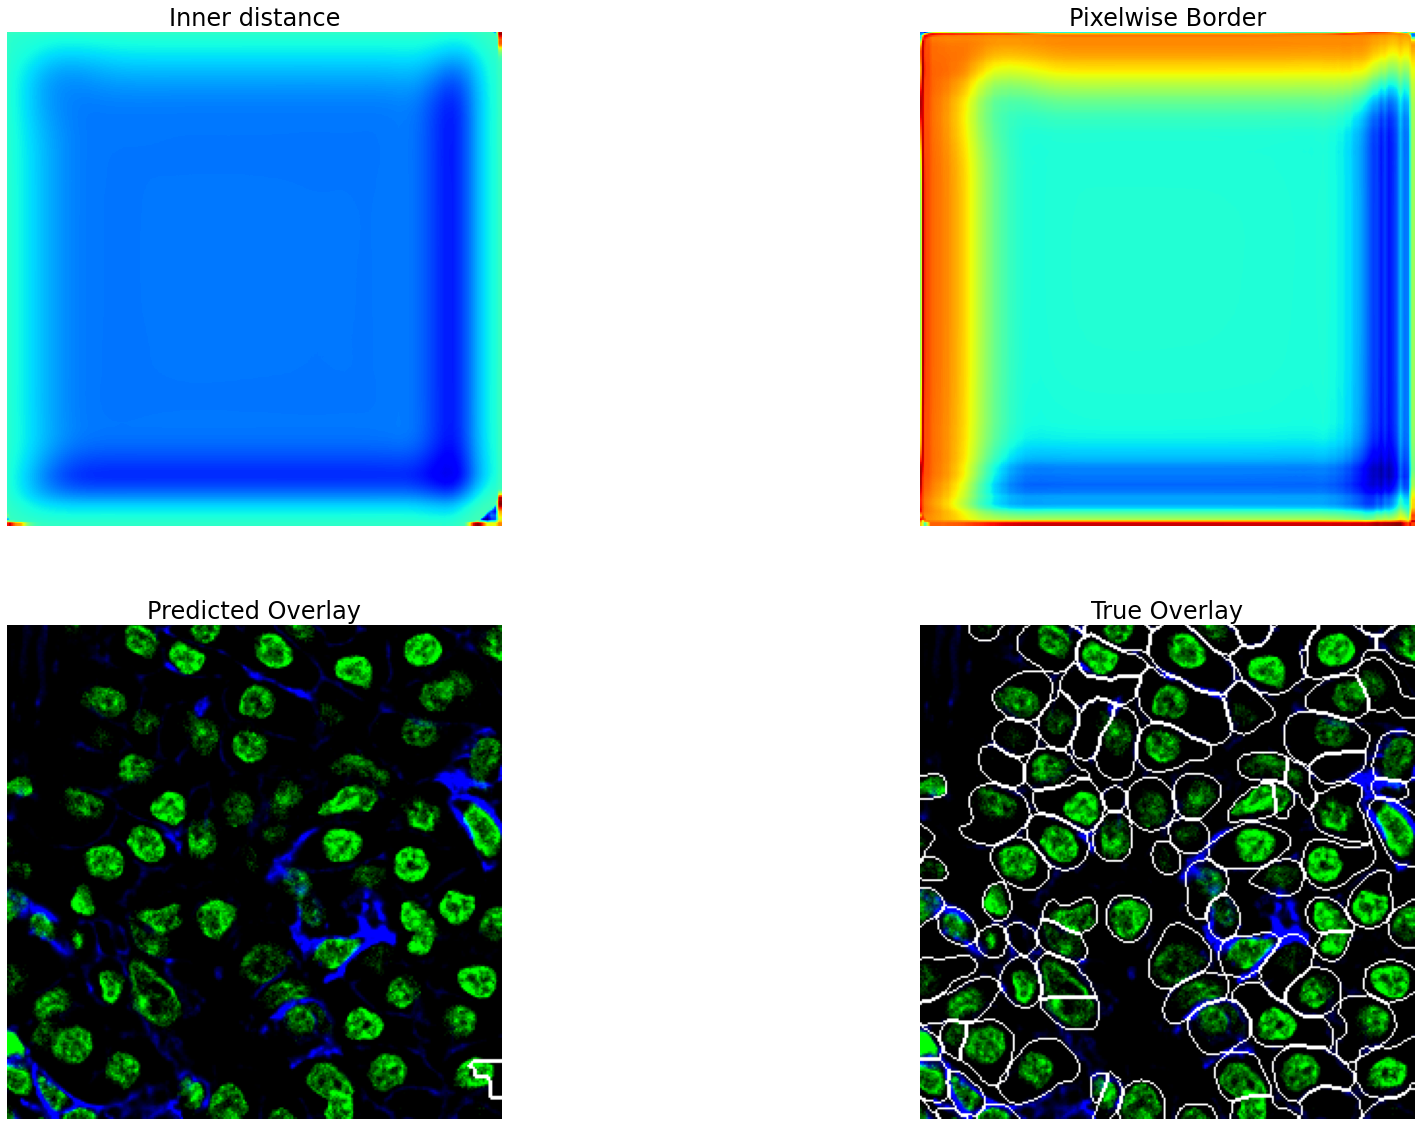

In [34]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = 96
fig, axes = plt.subplots(2,2,figsize=(30,20))

axes = axes.flatten()
axes[0].imshow(inner_distance[index,...,0], cmap='jet')
axes[1].imshow(pixelwise[index,...,1], cmap='jet')
axes[2].imshow(predicted_overlay[index, ...], cmap=cmap)
axes[3].imshow(true_overlay[index, ...], cmap=cmap)

axes[0].set_title('Inner distance', fontsize=24)
axes[1].set_title('Pixelwise Border', fontsize=24)
axes[2].set_title('Predicted Overlay', fontsize=24)
axes[3].set_title('True Overlay', fontsize=24)

for ax in axes.flatten():
    ax.set_axis_off()